In [260]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from seaborn import boxplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# added
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [173]:
#%pip install xgboost

In [262]:
data=pd.read_csv('Data/Iowa1.csv')
data.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),Soil type,...,Sand Content %,Clay Content %,Silt Content %,soil bulk density (grams per cubic centimeter),wilting point %,field capacity %,saturation point (cm),Yield (27.6gN/m2),Yield (11.6gN/m2),Yield (40.1gN/m2)
0,1982,1,32486.40039,4,185.600006,24,-7.5,-22.0,120,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
1,1982,2,32486.40039,9,176.000000,32,-1.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
2,1982,3,32486.40039,10,169.600006,40,-2.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
3,1982,4,32486.40039,9,124.800003,52,-7.0,-14.5,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
4,1982,5,32486.40039,0,252.800003,52,-2.0,-16.5,160,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0


In [264]:
#Data drop for US data
data = data.drop('year',axis=1)
data = data.drop('Soil type',axis=1)
data = data.drop('swe (kg/m^2)',axis=1)
data = data.drop('Soil pH',axis=1)
data = data.drop('Yield (40.1gN/m2)',axis=1)
data = data.drop('Yield (11.6gN/m2)',axis=1)
data = data.drop(' soil bulk density (grams per cubic centimeter)',axis=1)
data = data.drop(' wilting point %',axis=1)
data = data.drop('field capacity %',axis=1)
data = data.drop('saturation point (cm)',axis=1)
data = data.drop('Soil Organic matter %',axis=1)
data = data.drop('Sand Content %',axis=1)
data = data.drop('Clay Content %',axis=1)
data = data.drop('Silt Content %',axis=1)


data.head()

,yday,dayl (s),prcp (mm/day),srad (W/m^2),tmax (deg c),tmin (deg c),vp (Pa),Yield (27.6gN/m2)
0,1,32486.40039,4,185.600006,-7.5,-22.0,120,0.0
1,2,32486.40039,9,176.000000,-1.0,-14.0,200,0.0
2,3,32486.40039,10,169.600006,-2.0,-14.0,200,0.0
3,4,32486.40039,9,124.800003,-7.0,-14.5,200,0.0
4,5,32486.40039,0,252.800003,-2.0,-16.5,160,0.0


In [228]:
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_data = data.values[:, :-1]
y_data = data.values[:, -1].reshape((-1, 1))
x_scaler.fit(x_data)
y_scaler.fit(y_data)
x_r_data = x_scaler.transform(x_data)
y_r_data = y_scaler.transform(y_data)

In [266]:
X_, y = x_r_data[:], y_r_data.reshape((1, -1))[0]

In [268]:
pca_model = PCA(n_components=3)
X = pca_model.fit_transform(X_)

In [270]:
models = {}
models["MLP"] = MLPRegressor(solver='adam', activation='relu', max_iter=1000, learning_rate_init=0.001, hidden_layer_sizes=(1, 1, 1))
models["R. Forest"] = RandomForestRegressor(n_estimators=100)

predictions = {}
colors = {"MLP":'green', "R. Forest":'black','Xgboost':'orange', "SVM":'blue',"gradient":'brown',"LinearReg":'yellow'} 
par_mse = []
par_rmse = []
par_rrmse = []
par_mae = []
par_r2 = []
performance_names = ["MSE", "RMSE", "RRMSE", "MAE", "R2"]
model_names = []

In [272]:
# added
lstm_model = Sequential()
lstm_model.add(Input(shape=(X.shape[1], 3)))
lstm_model.add(LSTM(units=400, return_sequences=True))#, kernel_regularizer=L1L2(l1=0.001, l2=0.001)
lstm_model.add(LSTM(units=496))#, kernel_regularizer=L1L2(l1=0.001, l2=0.001)
lstm_model.add(Dense(1))

lstm_model.compile(loss='mse', optimizer=Adam(learning_rate=0.009000000000000001))

# Implement early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) / , callbacks=[early_stop]

lstm_model.fit(X.reshape(-1, 1, X.shape[1]), y, epochs=100, batch_size=30, validation_split=0.2, verbose=0)

lstm_predictions = lstm_model.predict(X.reshape(-1, 1, X.shape[1]))

inv_lstm_preds = y_scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).reshape((1, -1))[0]

mse_ls = mean_squared_error(y, lstm_predictions)
par_mse.append(mse_ls)
rmse_ls = math.sqrt(par_mse[-1])
par_rmse.append(rmse_ls)
rrmse_ls = par_rmse[-1]/np.mean(y)
par_rrmse.append(rrmse_ls)
mae_ls = mean_absolute_error(y, lstm_predictions)
par_mae.append(mae_ls)
r2_ls = r2_score(y, lstm_predictions)
par_r2.append(r2_ls)
model_names.append('LSTM')
predictions['LSTM'] = lstm_predictions
colors['LSTM'] = 'purple'

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


H:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


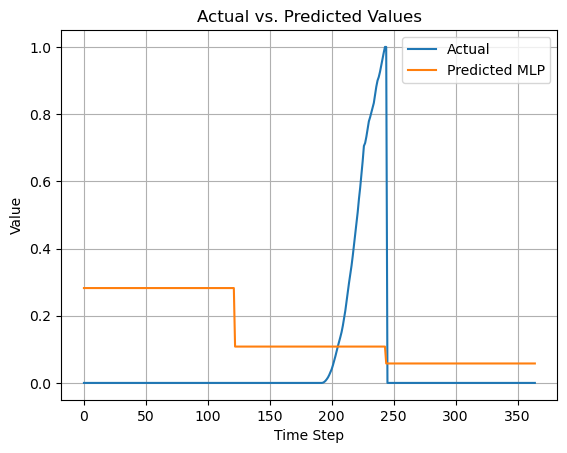

MLP       =>  RMSE = 0.2551  RRMSE = 3.8888  MAE = 0.1895  R2 = -0.5128


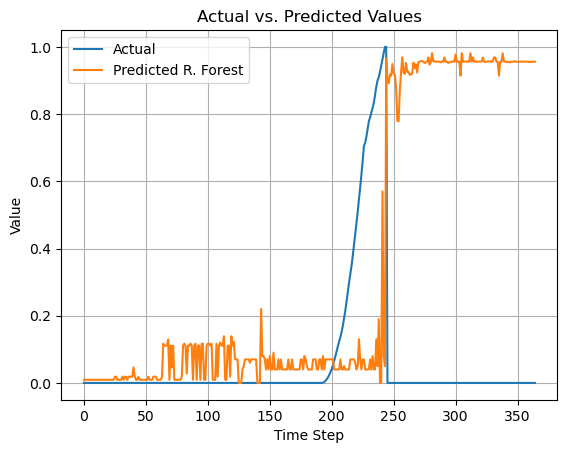

R. Forest  =>  RMSE = 0.5774  RRMSE = 8.8031  MAE = 0.3920  R2 = -6.7522


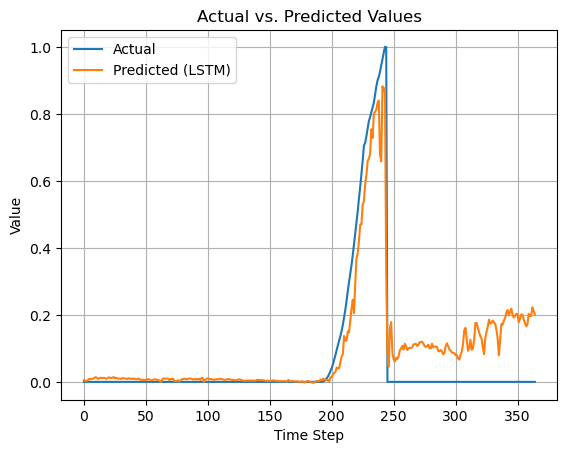

LSTM  =>  RMSE = 0.0965  RRMSE = 1.4714  MAE = 0.0613  R2 = 0.7834


In [274]:
for name in models:
    model_names.append(name)
    models[name].fit(X,y)
    y_pred = cross_val_predict(models[name], X, y,cv=3)
    predictions[name] = y_pred
    
    mse = mean_squared_error(y, y_pred)
    rmse =math.sqrt(mse)
    rrmse=rmse/np.mean(y)
    mae=mean_absolute_error(y, y_pred)
    r2=r2_score(y, y_pred)
    par_mse.append(mse)
    par_rmse.append(rmse)
    par_rrmse.append(rrmse)
    par_mae.append(mae)
    par_r2.append(r2)
    print('{:8s}'.format(name), ' =>  RMSE = {:.4f}'.format(rmse),' RRMSE = {:.4f}'.format(rrmse) ,' MAE = {:.4f}'.format(mae), ' R2 = {:.4f}'.format(r2)) #MSE = {:.4f}'.format(mse)

print('LSTM', ' =>  RMSE = {:.4f}'.format(rmse_ls),' RRMSE = {:.4f}'.format(rrmse_ls) ,' MAE = {:.4f}'.format(mae_ls), ' R2 = {:.4f}'.format(r2_ls)) 

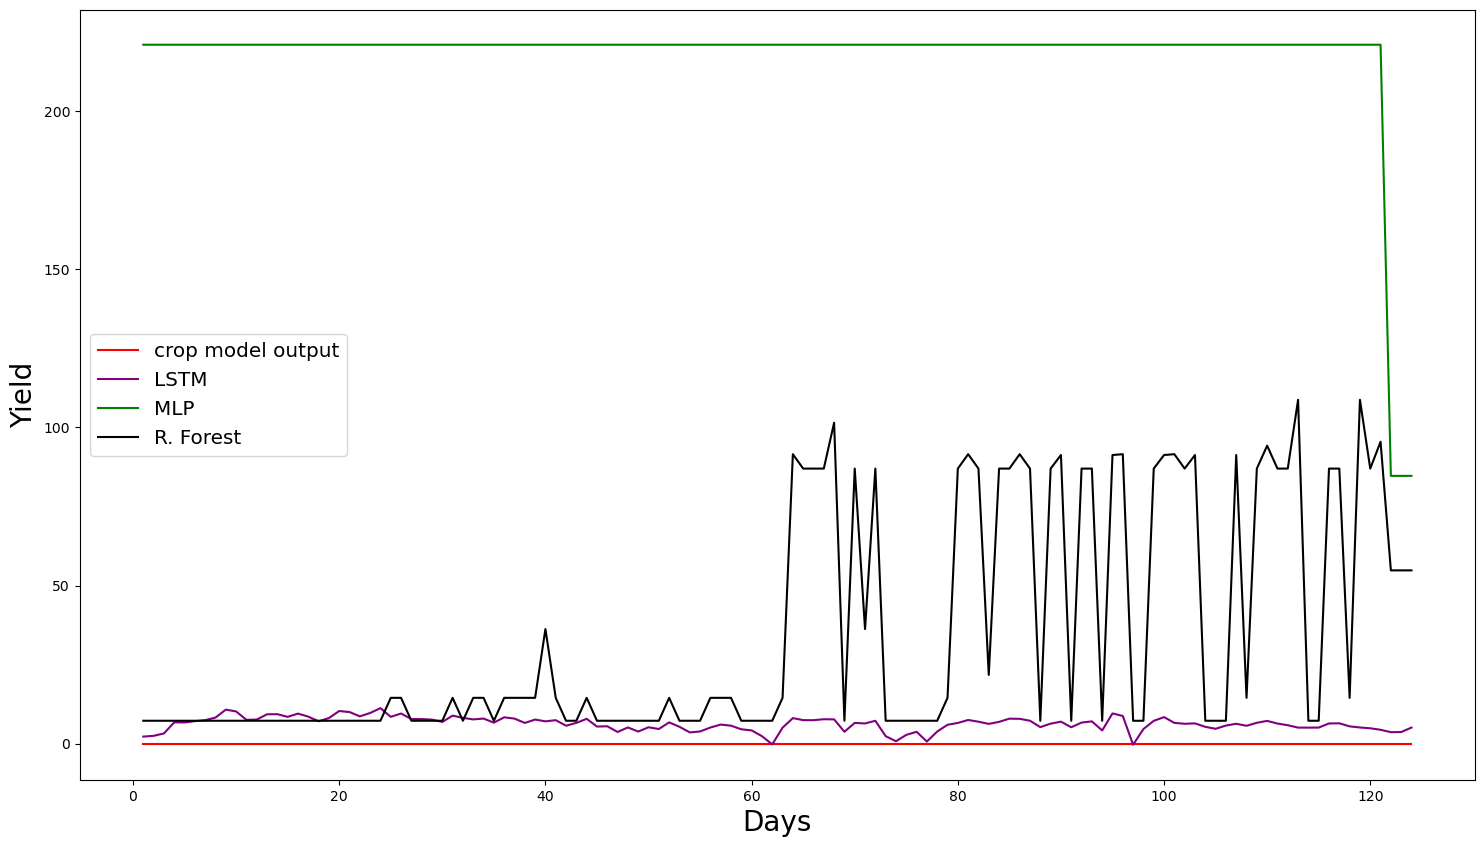

In [276]:
t_range = [i for i in range(1, 125)] 
plt.figure(figsize=(18, 10))
plt.plot(t_range, y_data[t_range], color='red', label="crop model output")
for name in predictions:
    inv_preds = y_scaler.inverse_transform(predictions[name].reshape((-1, 1))).reshape((1, -1))[0]
    plt.plot(t_range, inv_preds[t_range], color=colors[name], label=name)
plt.legend(fontsize="x-large")    
plt.xlabel('Days', fontsize=20)
plt.ylabel('Yield', fontsize=20)
plt.show()

LSTM
MLP
R. Forest


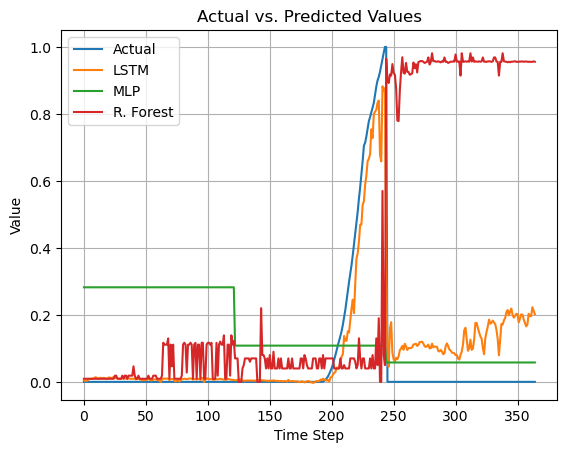

In [278]:
plt.plot(y, label='Actual')
for name in predictions:
    print(name)
    plt.plot(predictions[name], label=name)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

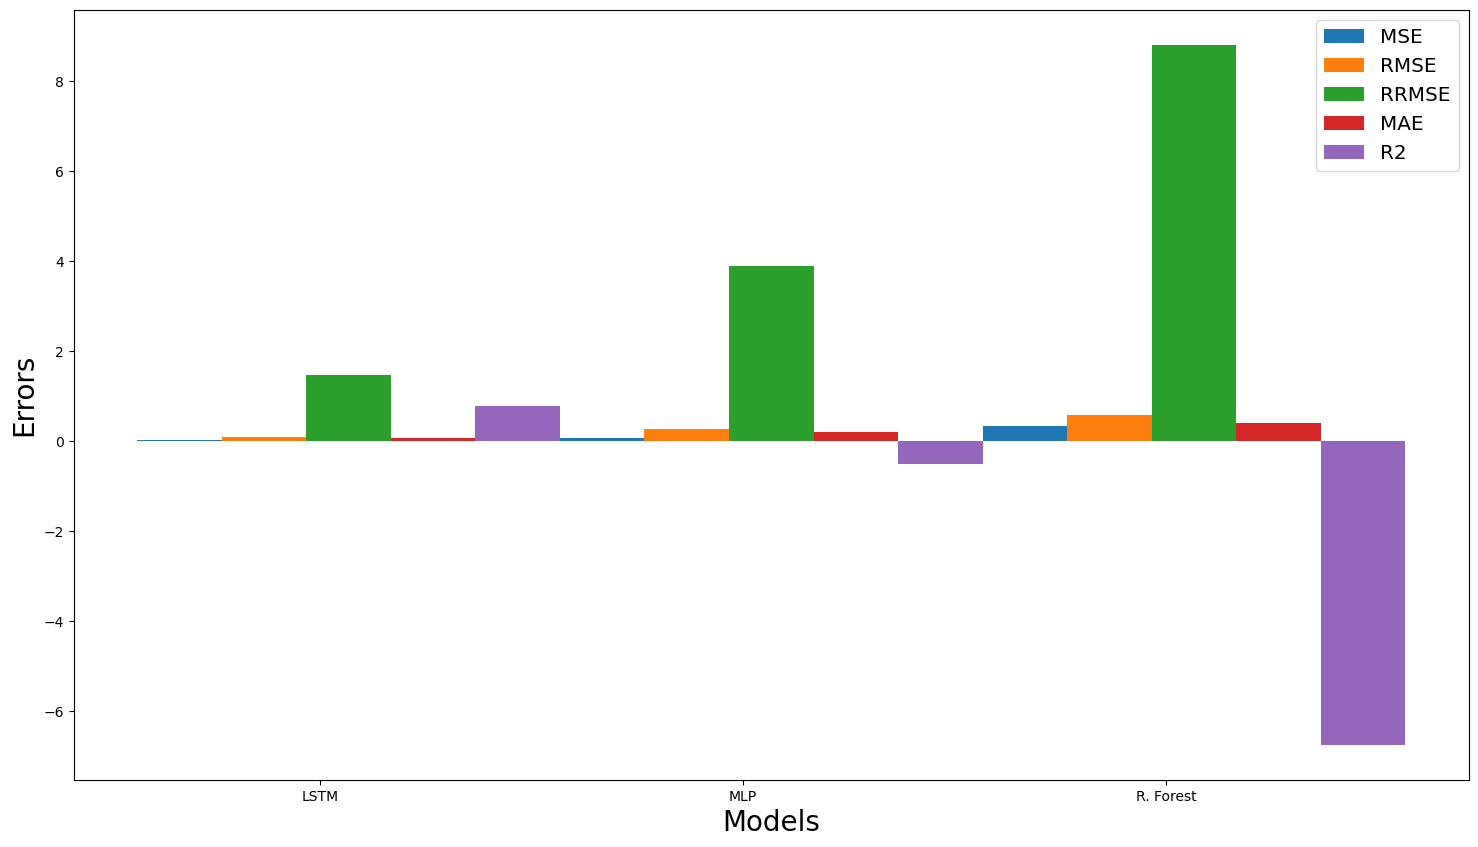

In [280]:
X_axis = np.arange(len(model_names))
plt.figure(figsize=(18, 10))
width = 0.2
r_width = 0
par = [par_mse, par_rmse, par_rrmse,par_mae, par_r2] 
for i, name in enumerate(performance_names):
    plt.bar(X_axis + r_width, par[i], width=width, label = name)
    r_width +=width
  
plt.xticks(X_axis+r_width/3, model_names)
plt.xlabel("Models", fontsize=20)
plt.ylabel("Errors", fontsize=20)
plt.legend(fontsize="x-large")
plt.show()